In [1]:
from ngsolve import *
import sys
sys.path.append('..\include')
from MatrixSolver import MatrixSolver as solver 
def HtoOmega(mesh, boundary, feOrder, H):
    fesOmega = H1(mesh, order=feOrder, definedon=mesh.Boundaries(boundary), complex=False)
    omega, psi= fesOmega.TnT()

    a = BilinearForm(fesOmega)
    a +=grad(omega).Trace()*grad(psi).Trace()*ds
    f=LinearForm(fesOmega)
    f += (grad(psi).Trace()*H)*ds
    with TaskManager():
        a.Assemble()
        f.Assemble()
    gfOmega=GridFunction(fesOmega)
    gfOmega=solver.iccg_solve(fesOmega, gfOmega, a, f.vec.FV(), tol=1.e-16, max_iter=200, accel_factor=0, complex=False) 
    return gfOmega

In [2]:
from netgen.meshing import *
from netgen.csg import *
from netgen.occ import *
from ngsolve import *
from ngsolve.webgui import Draw
from netgen.webgui import Draw as DrawGeo
import math
import numpy as np
import sys
sys.path.append(r'..\..\bin\Release') 
from EMPY_Field import *
sys.path.append('..\model')
from Cylinder_Yaxis_1Layer import Cylinder_Yaxis_1Layer
sys.path.append('..\include')
from MatrixSolver import MatrixSolver as solver 
#from HtoOmega import HtoOmega
model=Cylinder_Yaxis_1Layer(sigma=5e7)
mesh=model.mesh
Draw(mesh)

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

BaseWebGuiScene

In [3]:
import math
jomega=True
f=0.1
if jomega==True:
    s=2j*math.pi*f
else:
    s=2*math.pi*f
Dirichlet=False
feorder=3
mu=4e-7*math.pi
symmetric_plane=model.symmetric_plane
Mu=model.Mu
Sigma=model.Sigma
reduced_region=model.reduced_region
total_region=model.total_region
conductive_region=model.conductive_region
air_region=model.air_region
total_boundary=model.total_boundary
reduced_boundary=model.reduced_boundary
conductor_boundary=model.conductor_boundary

In [4]:

field=UNIF(0,1,0,0)
Ov=Ofield(field)
Bv=Bfield(field)
Hv=Bv/mu
Os=model.ReducedField(Ov, 0)
Bs=model.ReducedField(Bv, (0,0,0))

if Dirichlet==True:
    fesOmega=H1(mesh, order=feorder, dirichlet=reduced_boundary, complex=jomega)
else:
    fesOmega=H1(mesh, order=feorder, complex=jomega)
fesT=HCurl(mesh, order=feorder, nograd=True, definedon=conductive_region, dirichlet=conductor_boundary, complex=jomega)     
fesTOmega=fesT*fesOmega
(T,omega),(W, psi) = fesTOmega.TnT() 
gfTOmega = GridFunction(fesTOmega)
gfT, gfOmega =gfTOmega.components
a= BilinearForm(fesTOmega)
a +=Mu*grad(omega)*grad(psi)*dx(air_region)
a +=Mu*(T+grad(omega))*(W+grad(psi))*dx(conductive_region)
a +=1/(s*Sigma)*curl(T)*curl(W)*dx(conductive_region)
with TaskManager():
    a.Assemble()
normal = specialcf.normal(mesh.dim)

In [5]:
surfaceOmega=HtoOmega(mesh, total_boundary, feorder, Hv)
# Calculate Dirichlet condition terms
#gfOmega.Set(Ov, BND, mesh.Boundaries(total_boundary))
gfOmega.Set(surfaceOmega, BND, mesh.Boundaries(total_boundary))

enter iccg_solve
Dof= 372    matrix size= 3138.0
結果のノルム: 1.1234789633486865e-08
power=  39788796660.769035


In [6]:
f = LinearForm(fesTOmega)
f +=Mu*grad(gfOmega)*grad(psi)*dx(reduced_region)
with TaskManager():
    f.Assemble() 
#remove components of the Dirichlet boundary
fcut = np.array(f.vec.FV())[fesTOmega.FreeDofs()]
np.array(f.vec.FV(), copy=False)[fesTOmega.FreeDofs()] = fcut

# Add Neumann condition terms
f += (normal*Bv)*psi*ds(total_boundary)
with TaskManager():
    f.Assemble()
gfTOmega = GridFunction(fesTOmega)   #Clear gfA
gfTOmega=solver.iccg_solve(fesTOmega, gfTOmega, a, f.vec.FV(), tol=1.e-10, max_iter=200, accel_factor=1.1, complex=jomega) 
gfT, gfOmega=gfTOmega.components

fesOt=H1(mesh, order=feorder, definedon=total_region, complex=jomega)
fesOr=H1(mesh, order=feorder, definedon=reduced_region, complex=jomega)
Ot=GridFunction(fesOt)
Orr=GridFunction(fesOr)
Oxr=GridFunction(fesOr)

Ot.Set(gfOmega,VOL, definedon=total_region)
Orr.Set(gfOmega,VOL, definedon=reduced_region)
Oxr.Set(surfaceOmega, BND, mesh.Boundaries(total_boundary))
#Oxr.Set(Ov, BND, mesh.Boundaries(total_boundary))

Bt=(gfT+grad(Ot))*Mu
Or=Orr-Oxr
Br=(grad(Orr)-grad(Oxr))*mu
Bfield=Bt+Br+Bs
Jfield=curl(gfT)

mip = mesh(0,0,0)
print("center magnetic field = ", Bfield(mip))


enter iccg_solve
Dof= 28280    matrix size= 2830309.0
結果のノルム: 2.456997505746952e-10
power=  (63067.047215205355+746.2385921008477j)
center magnetic field =  ((-4.382513314253391e-06+2.694537638171107e-06j), (1.434685108232072-0.9206111581272192j), (-1.5556290839097792e-12+3.507768805507746e-10j))


In [7]:
if jomega==False:
    WJ=Integrate(Jfield*Jfield/Sigma*dx(conductive_region, mesh))
else:
    WJ=Integrate((Jfield.real*Jfield.real+Jfield.imag*Jfield.imag)/Sigma*dx(conductive_region), mesh) /2
print(" Average Joule loss= ", WJ)

 Average Joule loss=  234.43776788148986


In [8]:
if jomega==True:
    print("****** Bfield.real ******")
    Draw (Bfield.real, mesh, order=3, deformation=False) 
    print("****** Bfield.imag ******")
    Draw (Bfield.imag, mesh, order=3, deformation=False) 
    print("****** Jfield.real ******")
    Draw (Jfield.real, mesh, order=3, deformation=False) 
    print("****** Jfield.imag ******")
    Draw (Jfield.imag, mesh, order=3, deformation=False) 
else:
    print("****** Bfield ******")
    Draw (Bfield, mesh, order=3, deformation=False) 
    print("****** Jfield ******")
    Draw (Jfield, mesh, order=3, deformation=False) 

****** Bfield.real ******


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

****** Bfield.imag ******


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

****** Jfield.real ******


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

****** Jfield.imag ******


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

Dirichlet=False feorder=3

Jz real [-1.24e6, 1.24e6]
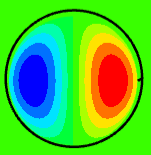

Jz imag [-5.55e6, 5.55e6]
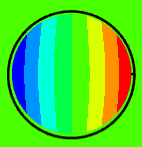

Average Joule loss=  234.43776788148986

